# RMs for RL

## Imports and notebook utils

In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

from pathlib import Path

from multi_taxi import single_taxi_v0

from rmrl.envs.grid import single_taxi
from rmrl.envs.grid.reward_machines.single_taxi import SingleFixedPassengerHighResRM
from rmrl.reward_machines.rm_env import RMEnvWrapper
from rmrl.reward_machines.potential_functions import DistFromGoal
from rmrl.nn.models import RMFeatureExtractorSB
from rmrl.utils.callbacks import TrueRewardRMEnvCallback

from gym.wrappers import TimeLimit

from stable_baselines3 import DDPG, DQN

MODELS_DIR = Path('./models')
LOGS_DIR = Path('./logs')
TB_DIR = LOGS_DIR / 'tensorboard'


RS_GAMMA = 0.9
MAX_ITERS = 1000
MAX_STEPS = 200

/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
from IPython.display import clear_output
import time
import sys

def get_dqn_trained_model(name, policy, env, timesteps, callback=None, **model_kwargs):
    model = DQN(policy=policy,
                env=env,
                verbose=1,
                tensorboard_log=TB_DIR / name,
                **model_kwargs)
    # load model if exists
    try:
        print('loading pre-trained model')
        return model.load(MODELS_DIR / name, model.env)
    except FileNotFoundError:
        print('pre-trained model not found. training model')
        train_model(model, timesteps, callback=callback)
        model.save(MODELS_DIR / name)
        return model

def train_model(model, timesteps, callback=None):
    try:
        iter(timesteps)
    except TypeError:
        timesteps = [timesteps]

    for i, ts in enumerate(timesteps, 1):
        print(f'run number {i}. {ts} timesteps')
        model.learn(total_timesteps=ts,
                    tb_log_name=f'run{i}',  # number the run logs
                    reset_num_timesteps=False,   # continue the same curve
                    callback=callback)

def animate_env(env, model, num_iters=MAX_ITERS, sleep=0.2):
    action_strings_map = env.unwrapped.get_action_meanings()
    step = 0
    try:
        obs = env.reset()
        print('step:', step)
        print('chose action:')
        env.render()
        for i in range(num_iters):
            action, _state = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            step += 1
            time.sleep(sleep)
            clear_output(wait=True)
            print('step:', step)
            print('chose action:', action_strings_map[int(action)])
            env.render()

            if done:
                time.sleep(sleep)
                clear_output(wait=True)
                step = 0
                obs = env.reset()
                print('step:', step)
                print('chose action:')
                env.render()
    except KeyboardInterrupt:
        print('Early stop by user')
    finally:
        env.close()

# Raw Env

In [3]:
taxi_env = single_taxi_v0.gym_env(pickup_only=True)
taxi_env.reset()
taxi_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : :P: : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (5, 9), Engine: ON, Collided: False, ALIVE
Passenger0-YELLOW: Location: (2, 9), Destination: (-1, -1)
Env done: False



In [4]:
taxi_env.reset()

array([ 5,  1,  5, 11,  0])

In [5]:
taxi_model = get_dqn_trained_model('dqn_pickup',
                                   'MlpPolicy',
                                   taxi_env,
                                   timesteps=2e5,  # 200k updates
                                   exploration_fraction=0.5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model


In [6]:
%tensorboard --logdir ./logs/tensorboard/dqn_pickup

In [7]:
# animate_env(taxi_env, taxi_model, sleep=0.2)

## Fixed passenger location

In [8]:
FIXED_PASSENGER_LOC_1 = (0, 0)

fixed_pass_env = single_taxi.fixed_entities_env(initial_goal_vel=(tuple(),
                                                                  FIXED_PASSENGER_LOC_1,
                                                                  tuple()),
                                                change_task_on_reset=False,
                                                pickup_only=True)

In [9]:
fixed_pass_env.reset()
print(f'pickup location: {fixed_pass_env.task[0]}')
print('location changes on reset'
      if fixed_pass_env.change_task_on_reset
      else 'fixed location')
fixed_pass_env.render()

pickup location: ()
fixed location
+-----------------------+
|P: |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (5, 5), Engine: ON, Collided: False, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (-1, -1)
Env done: False



In [10]:
fixed_pass_model = get_dqn_trained_model('dqn_fixed_pass',
                                         'MlpPolicy',
                                         fixed_pass_env,
                                         timesteps=2e5,  # 200k updates
                                         exploration_fraction=0.5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model


In [11]:
%tensorboard --logdir ./logs/tensorboard/dqn_fixed_pass

In [12]:
# animate_env(fixed_pass_env, fixed_pass_model)

## Passenger Fix w/ Reward Shaping SIMPLE

In [13]:
pot_fn = DistFromGoal(goal_state=2)
simple_rm = SingleFixedPassengerHighResRM(taxi_loc_idx=[0, 1],
                                            pass_loc_idx=[2, 3],
                                            pickup_ind_idx=4,
                                            resolution=(1, 1),
                                            dm=fixed_pass_env.unwrapped.domain_map)

simple_rm.new_task(fixed_pass_env.task)
pot_fn = DistFromGoal(goal_state=max(simple_rm.F))
pots = pot_fn(simple_rm, RS_GAMMA)
simple_rm.reshape_rewards(pots, RS_GAMMA)
def rm_fn(env):
    return [simple_rm]

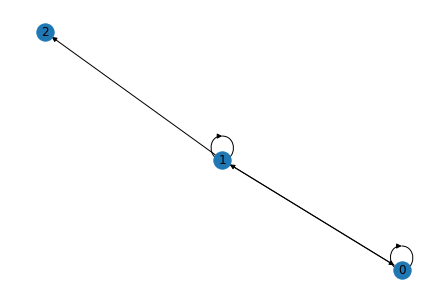

In [14]:
simple_rm.draw(with_labels=True)

In [15]:
fixed_pass_env_rm = RMEnvWrapper(fixed_pass_env, rm_fn,
                                 rm_observations=False,
                                 change_rms_on_reset=False)
fixed_pass_env_rm.reset()
fixed_pass_env_rm.render()

+-----------------------+
|P: |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (6, 0), Engine: ON, Collided: False, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (-1, -1)
Env done: False



In [16]:
cb = TrueRewardRMEnvCallback()

fixed_pass_model_rm = get_dqn_trained_model('dqn_fixed_pass_rm',
                                            'MlpPolicy',
                                            fixed_pass_env_rm,
                                            timesteps=2e5,  # 200k updates
                                            callback=cb,
                                            exploration_fraction=0.5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model


In [17]:
%tensorboard --logdir ./logs/tensorboard/dqn_fixed_pass_rm

In [18]:
# animate_env(fixed_pass_env_rm, fixed_pass_model_rm)

## Passenger Fix w/ Reward Shaping HIGH-RES

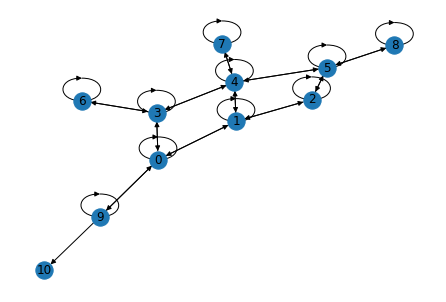

In [19]:
high_res_rm = SingleFixedPassengerHighResRM(taxi_loc_idx=[0, 1],
                                            pass_loc_idx=[2, 3],
                                            pickup_ind_idx=4,
                                            resolution=(3, 3),
                                            dm=fixed_pass_env.unwrapped.domain_map)
high_res_rm.new_task(fixed_pass_env.task)
pot_fn = DistFromGoal(goal_state=max(high_res_rm.F))
pots = pot_fn(high_res_rm, RS_GAMMA)
high_res_rm.reshape_rewards(pots, RS_GAMMA)
def rm_fn(env):
    return [high_res_rm]

high_res_rm.draw(with_labels=True)

In [20]:
fixed_pass_env_rm_hd = RMEnvWrapper(fixed_pass_env, rm_fn,
                                    rm_observations=False,
                                    change_rms_on_reset=False)
fixed_pass_env_rm_hd.reset()
fixed_pass_env_rm_hd.render()

+-----------------------+
|P: |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (6, 0), Engine: ON, Collided: False, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (-1, -1)
Env done: False



In [21]:
cb = TrueRewardRMEnvCallback()

fixed_pass_model_rm_hd = get_dqn_trained_model('dqn_fixed_pass_rm_hd',
                                               'MlpPolicy',
                                               fixed_pass_env_rm_hd,
                                               timesteps=2e5,  # 200k updates
                                               callback=cb,
                                               exploration_fraction=0.5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model


In [22]:
%tensorboard --logdir ./logs/tensorboard/dqn_fixed_pass_rm_hd

In [23]:
# animate_env(fixed_pass_env_rm_hd, fixed_pass_model_rm_hd)

## Passenger Fix w/ RS + abstract state

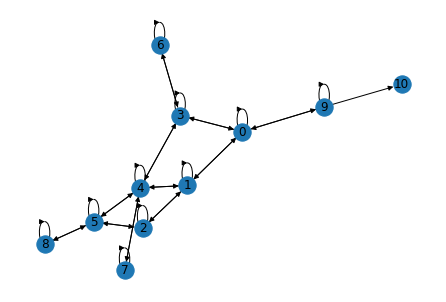

In [24]:
rm_as = SingleFixedPassengerHighResRM(taxi_loc_idx=[0, 1],
                                      pass_loc_idx=[2, 3],
                                      pickup_ind_idx=4,
                                      resolution=(3, 3),
                                      dm=fixed_pass_env.unwrapped.domain_map)
rm_as.new_task(fixed_pass_env.task)
pot_fn = DistFromGoal(goal_state=max(rm_as.F))
pots = pot_fn(rm_as, RS_GAMMA)
rm_as.reshape_rewards(pots, RS_GAMMA)
def rm_fn(env):
    return [rm_as]

rm_as.draw(with_labels=True)

In [25]:
fixed_pass_env_rm_as = RMEnvWrapper(fixed_pass_env, rm_fn,
                                    rm_observations=False,
                                    change_rms_on_reset=False,
                                    abstract_state_indicator=True)
fixed_pass_env_rm_as.reset()
fixed_pass_env_rm_as.render()

+-----------------------+
|P: |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (6, 3), Engine: ON, Collided: False, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (-1, -1)
Env done: False



In [26]:
fixed_pass_env_rm_as.observation_space

Dict(obs: Box(0.0, [ 7. 12.  7. 12.  2.], (5,), float32), rm0_cur_state: Box(0.0, 1.0, (11,), float32))

In [27]:
policy_kwargs = dict(
    features_extractor_class=RMFeatureExtractorSB
)

cb = TrueRewardRMEnvCallback()

fixed_pass_model_rm_as = get_dqn_trained_model('dqn_fixed_pass_rm_as',
                                               'MultiInputPolicy',
                                               fixed_pass_env_rm_as,
                                               timesteps=2e5,  # 200k updates
                                               callback=cb,
                                               exploration_fraction=0.5,
                                               # policy_kwargs=policy_kwargs
                                              )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model


In [28]:
%tensorboard --logdir ./logs/tensorboard/dqn_fixed_pass_rm_as

In [29]:
# animate_env(fixed_pass_env_rm_as, fixed_pass_model_rm_as)

## Passenger Fix w/ RS + abstract propositions

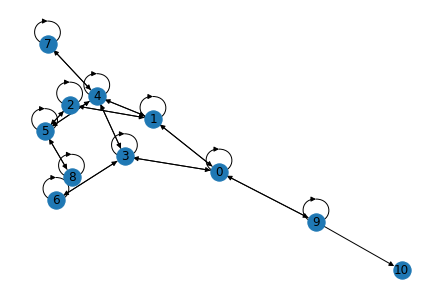

In [30]:
rm_ap = SingleFixedPassengerHighResRM(taxi_loc_idx=[0, 1],
                                      pass_loc_idx=[2, 3],
                                      pickup_ind_idx=4,
                                      resolution=(3, 3),
                                      use_prop_vector_attr=True,
                                      dm=fixed_pass_env.unwrapped.domain_map)
rm_ap.new_task(fixed_pass_env.task)
pot_fn = DistFromGoal(goal_state=max(rm_ap.F))
pots = pot_fn(rm_ap, RS_GAMMA)
rm_ap.reshape_rewards(pots, RS_GAMMA)
def rm_fn(env):
    return [rm_ap]

rm_ap.draw(with_labels=True)

In [31]:
fixed_pass_env_rm_props = RMEnvWrapper(fixed_pass_env, rm_fn,
                                    rm_observations=False,
                                    change_rms_on_reset=False,
                                    abstract_props_vector=True)
fixed_pass_env_rm_props.reset()
fixed_pass_env_rm_props.render()

+-----------------------+
|P: |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (5, 0), Engine: ON, Collided: False, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (-1, -1)
Env done: False



In [32]:
policy_kwargs = dict(
    features_extractor_class=RMFeatureExtractorSB
)

cb = TrueRewardRMEnvCallback()

fixed_pass_model_rm_props = get_dqn_trained_model('dqn_fixed_pass_rm_props',
                                               'MultiInputPolicy',
                                               fixed_pass_env_rm_props,
                                               timesteps=2e5,  # 200k updates
                                               callback=cb,
                                               exploration_fraction=0.5,
                                               policy_kwargs=policy_kwargs
                                              )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model
pre-trained model not found. training model
run number 1. 200000.0 timesteps
Logging to logs/tensorboard/dqn_fixed_pass_rm_props/run1_0
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1.37e+03  |
|    ep_rew_mean      | 900       |
|    ep_true_rew_mean | -1.27e+03 |
|    exploration rate | 0.948     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 2613      |
|    time_elapsed     | 2         |
|    total timesteps  | 5486      |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1.78e+03  |
|    ep_rew_mean      | 869       |
|    ep_true_rew_mean | -2.09e+03 |
|    exploration rate | 0.865     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 

In [33]:
%tensorboard --logdir ./logs/tensorboard/dqn_fixed_pass_rm_props

In [34]:
# animate_env(fixed_pass_env_rm_props, fixed_pass_model_rm_props)

In [ ]:
mymap = [
    "+-------+",
    "| : | : |",
    "| : : : |",
    "| : | | |",
    "| | | : |",
    "+-------+"
]

In [ ]:
FIXED_TAXI_LOC_1 = (3, 1)
FIXED_PASSENGER_LOC_1 = (0, 2)
FIXED_PASSENGER_DST_1 = (0, 0)

st_env = single_taxi.fixed_entities_env(initial_goal_vel=(FIXED_TAXI_LOC_1,
                                                          FIXED_PASSENGER_LOC_1,
                                                          FIXED_PASSENGER_DST_1),
                                        change_task_on_reset=False,
                                        domain_map=mymap,
                                        max_steps=200)

In [ ]:
st_env.reset()
# s = st_env.state()
# s.taxis[0].location = (3, 1)
# s.passengers[0].location = (0, 2)
# s.passengers[0].destination = (0, 0)
# st_env.unwrapped.set_state(s)
st_env.render()

In [ ]:
m = get_dqn_trained_model('dqn_fixed_pass_small',
                          'MlpPolicy',
                          st_env,
                          timesteps=2e5,  # 200k updates
                          exploration_fraction=0.5,
                          # policy_kwargs=policy_kwargs
                          )

In [ ]:
st_env.reset()
s = st_env.state()
s.taxis[0].location = (0, 3)
s.passengers[0].location = (2, 3)
s.passengers[0].destination = (3, 3)
st_env.unwrapped.set_state(s)
st_env.render()

In [ ]:
fixed_vel_env_rs_graph_input = RMEnvWrapper(fixed_vel_env, rm_fn,
                                            rm_observations=True,
                                            change_rms_on_reset=False)

In [ ]:
## TODO support policy_kwargs in "get_ddpg_trained_model" function
policy_kwargs = dict(
    features_extractor_class=RMFeatureExtractorSB
)

model_vel_rs_gnn = DDPG('MultiInputPolicy',
                        fixed_vel_env_rs_graph_input,
                        verbose=1,
                        tensorboard_log="./ddpg_cheetah_vel5.0_rs_gnn_tensorboard/",
                        policy_kwargs=policy_kwargs,
                        batch_size=1)
model_vel_rs_gnn.learn(total_timesteps=100_000, tb_log_name="first_run", reset_num_timesteps=False)
model_vel_rs_gnn.learn(total_timesteps=100_000, tb_log_name="second_run", reset_num_timesteps=False)
model_vel_rs_gnn.learn(total_timesteps=100_000, tb_log_name="third_run", reset_num_timesteps=False)
model_vel_rs_gnn.learn(total_timesteps=100_000, tb_log_name="fourth_run", reset_num_timesteps=False)

In [ ]:
%tensorboard --logdir ./ddpg_cheetah_vel5.0_rs_gnn_tensorboard/

In [ ]:
# animate_env(fixed_vel_env_rs_graph_input, model_vel_rs_gnn)